# JojaMart Catalogue Challenge (Notebook 2 of 2)

### <span style="color:orange">Find more of my work [here on GitHub](https://github.com/rvbrooks)!</span>

In notebook 1, I demonstrated EDA of JojaMart's data.

Now, I work through selecting a model to predict which products JojaMart will discontinue.

1. I test a simple Logistic Regression model
2. I train a more complex Random Forest model
3. I wrap the trained model into a data pipeline for JojaMart.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

catalogue_discontinuation = pd.read_csv("datasheet_1.csv") 
product_details = pd.read_csv("datasheet_2.csv")
df = pd.merge(catalogue_discontinuation, product_details, how="inner", on="ProductKey")

### 4. Model Selection
#### 4.a: Simple Logistic Regression Model

Since this is a binary classification problem, I will start by trying a simple logistic regression model, which I know to be a relatively **simple and computationally light** model (compared to some others e.g. neural nets).

I will use the scikit-learn (sklearn) machine learning library here.

Logistic regression is a supervised learning model: I will use the "DiscontinuedTF" column as the target variable for training, and the remaining columns of the dataframe as the features.

Then I need to split the dataframe in to a training set and a test set, which I do using sklearn's train_test_split functionality. I choose to split 30% of my data into a test set. 

Note that since we have 3.6 million samples I choose not to use k-fold cross-validation (CV) here - it's computationally expensive for that many samples. Since there are so many samples, I expect that k-fold CV is not necessary (later, I use OOB evaluation instead).

In [10]:
from sklearn.model_selection import train_test_split

y = df["DiscontinuedTF"]   # Define my target variable column y
X = df.drop(["DiscontinuedTF"], axis=1) # Define my matrix of feature variables X={x1, x2, ...}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

With the data split into train and test sets, I can now fit the model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)


def print_classifier_scores(y_pred, y_test):
    """
    Convenience function for printing multiple classification metrics at once
    ---
    Inputs: 
        - predicted labels
        - actual labels:
    Returns:
        - None
        - (Prints scoring metrics)
    """
    print(confusion_matrix(y_pred, y_test))
    print("The accuracy is {}".format(accuracy_score(y_pred, y_test)))
    print("The recall is {}".format(recall_score(y_pred, y_test)))
    print("The precision is {}".format(precision_score(y_pred, y_test)))

print_classifier_scores(y_pred, y_test)

auc = roc_auc_score(y_pred, y_test)  # ROC curve is true positive rate vs false positive rate as decision surface is varied

print("The ROC AUC score is : {}".format(auc)) 

[[636526 393430]
 [ 19264  38478]]
The accuracy is 0.6205803449119149
The recall is 0.6663780263932666
The precision is 0.0890884169776897
The ROC AUC score is : 0.6421954173537041


The accuracy of this model is 62% - this is not particularly good. From the confusion matrix, it is apparent that the reason is due to the high number of False Negatives being predicted, that is, many products which are actually discontinued are incorrectly being predicted as *not* discontinued - i.e. the precision is low.

Furthermore the AUC score, which computes the area under the ROC curve is ~0.64, which is considered a poor score.

This suggests the model is **insufficiently complex**, and therefore has a high bias (underfitting). I will test out a more complex model to see how that compares.

#### 4. b: More Complex Random Forest Model

Since the logistic regression didn't return a great efficiency, I will try a more complex model which may be able to capture the data better. 

I will try a Random Forest, since I know it is a great model in general, due to its flexibility and ability to be trained on a mix of categorical and continuous data. It is also insensitive to feature scaling.

I will use the Gini coefficient to calculate the information gain when constructing the decision trees. This is because it tends to be computationally faster than alternatives like the entropy, which is appreciated by my laptop.

In [12]:
from sklearn.ensemble import RandomForestClassifier
import timeit

import warnings    # Ignore some warnings which are raised by sklearn when fitting Random Forests
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)


rf_model= RandomForestClassifier(n_estimators = 10, max_depth = 10, criterion = "gini", oob_score = True, random_state=1) 

start_time = timeit.default_timer()

rf_model.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time

print(elapsed)

y_pred = rf_model.predict(X_test)

print_classifier_scores(y_pred, y_test)

35.1632295
[[611300  39085]
 [ 44490 392823]]
The accuracy is 0.9231634148449294
The recall is 0.898265087020052
The precision is 0.9095061911332969


From now on, I'll use the OOB (out-of-bag) score to evaluate the Random Forest model on unseen data. This saves computational time compared to k-fold cross-validation, by using the data that wasn't selected for the bootstrapped sample as the test set.




In [13]:
print(rf_model.oob_score_)

0.9165219638914861


The OOB score is similar to the test set prediction score.

The more complex Random Forest model has an accuracy of ~92%, which is a significant improvement compared to the logistic regression model!

This looks like the way forwards, so I will focus on optimising the random forest.


### 5. Random Forest Model Optimisation

Now, the goal will be to improve the performance of the Random Forest model via hyperparameter tuning, and feature engineering.

#### 5.a Feature Importance and Feature Re-Engineering

Usefully, sklearn's RandomForestClassifier calculates the importance of all the features in the model by recording how often they were all used to determine the information gain at each split of the decision trees in the forest. 

I can examine this information, and use it to eliminate uninformative features, thus speeding up my subsequent model optimisation.

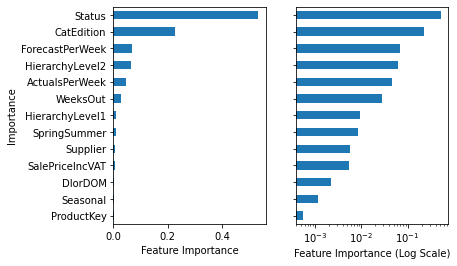

In [14]:
importances = pd.Series(rf_model.feature_importances_, index = X.columns)
importances = importances.sort_values()


fig, axes = plt.subplots(nrows=1, ncols=2)
importances.plot(kind="barh", ylabel = "Importance", ax = axes[0])
importances.plot(kind="barh", logx=True)  # Log scale gives idea of order of magnitude differences.

axes[0].set_xlabel('Feature Importance')
axes[1].set_yticklabels([])
axes[1].set_xlabel('Feature Importance (Log Scale)')

plt.show()                                

This plot of feature importances is useful and in some cases surprising:

1. Status is a strong predictor as expected. I believe it's acceptable to use this in the training of the model because for the future catalogue we will be able to see if a product has been marked for discontinuation or not.
2. Forecast per week and Actuals per week are similar -> I expect they are correlated. However, random forest is pretty good for preventing against this kind of issue.
3. CatEdition is a surprisingly strong predictor. This is **bad** because the model has essentially been trained on a useless number - we care about the *next* catalogue.
4. Surprisingly, seasonality is *not* a good predictor of if a line will be discontinued. I thought it would be more important.


Going forwards, **it is clear that "CatEdition" should be dropped**, since:
* The model has clearly learned to use CatEdition to predict
* CatEdition is not an available variable for prediction of future catalogues 
    * I believe the training on CatEdition is a case of **leakage**, so it must be dropped.
    * Since there aren't many features, I won't eliminate any remaing features or engineer any.

In [15]:
X = X.drop(["CatEdition"], axis=1)

X.columns

# Define the training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=1)


Note that I have defined a training set (70%) and a *holdout* set (30%). 

Since I am using OOB evaluation, I don't need to explicitly partition a test set of data. The holdout data set will be used after the model's hyperparameters have been tuned, and will be used to estimate the final model's generalisation accuracy.


#### 5.b Hyperparameter Tuning

Now to optimise the model I will tune some important hyperparameters of the random forest. The hyperparameters available to me to tune are as follows:

In [16]:
RF = RandomForestClassifier(criterion = "gini", random_state = 1) 
RF.get_params()  # list the hyperparameters that are available to me to tune

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

The most accurate method would be to grid search the space of hyperparameters exhaustively. For each combination of hyperparameters, I would do a k-fold cross validation (CV), which is a robust method of evaluating a model, since it averages over the particular choice of training data.

However the main drawback of this approach is computation time, which is long due to the 3.6M data points and given the computational power available to me. 

Currently, a single random forest is taking ~30 seconds to calculate for a relatively low 10 trees of max depth 10. If I were to grid search 16 parameters, with 10-fold CV, I could expect it to take at *least* 1hr20, but more like 2hrs if I increase the number of trees or the max tree depth.

#### OOB Evaluation for Hyperparameter Tuning a Random Forest

Fortunately, for random forest I can use an **OOB** (Out-Of-Bag) evaluation strategy. The OOB value is expected to approach the k-fold CV score as the data set becomes large, and be computationally more efficient. OOB uses the data that was not included in the bootstrapped training data set for a given tree as the test set.

I believe using the OOB score is justified in this case as my goal at this stage is to optimise hyperparameters in a reasonable amount of time. k-fold CV is typically more effective on smaller datasets - since our dataset is large, I wouldn't expect much improvement when using it anyways.

A further benefit is that bootstrapping the data introduces further randomness, reducing the risk of overfitting the model. The large dataset should also help prevent overfitting.

#### Search Strategy

Rather than using a brute-force grid search strategy to assess all combinations of all hyperparameters (which is computationally expensive), I will do a more targeted search:
1. I will choose a few of the most important Random Forest hyperparameters
2. I will assume they can be optimised independently
3. I will grid search a single hyperparameter at a time, choosing the others to yield quick computation time.
4. When all have been searched I will set all to optimum and I will then retrain the final model
5. I will test the finalised model on the unseen holdout set.


Inconveniently, there does not seem to be the sklearn functionality to use OOB_score to tune hyperparameters (you can use k-fold CV instead). Therefore I need to write my own function.



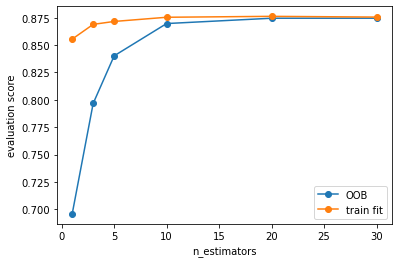

In [17]:
def OOB_hyperparameter_grid(d, hyperparameter = "max_len"):
    """
    Function to do a grid search at specified values of a singel hyperparameter
    ---
    Inputs:
        - d: a dictionary of the 5 hyperparameters of interest. The fixed hyperparameters are specified as list of length 1
             the hyperparameter we are varying is of arbitrary length
        - hyperparameter: the argument name of the hyperparameter to vary as a string
    ---
    Outputs:
        - A plot of the model OOB accuracy score as a function of the varying hyperparameter.
          the accuracy measured on the training set is also returned.
    """
    
    maxlen = max(len(item) for item in d.values())
    for k, v in d.items():   # This loop is to check which is the hyperparameter to vary (longest length list)
        if len(v) < maxlen:  # then set other lists to this length.
            d[k] = v * maxlen

    train_accuracy_list = []
    OOB_list = []
    
    # Need to loop over the hyperparameter and evaluate model at each value specified
    for i in range(maxlen):
        model = RandomForestClassifier(n_estimators = d["n_estimators"][i], 
                                       max_depth = d["max_depth"][i], 
                                       min_samples_leaf = d["min_samples_leaf"][i], 
                                       min_samples_split = d["min_samples_split"][i], 
                                       max_features = d["max_features"][i],
                                       criterion = "gini",
                                       random_state = 1,
                                       oob_score = True)
        
        # fit the model and make predictions.
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train_pred, y_train)
        train_accuracy_list.append(train_accuracy)
        OOB_list.append(model.oob_score_)
        
    # Plot the results:
    plt.plot(d[hyperparameter], OOB_list, marker='o', label='OOB')
    plt.plot(d[hyperparameter], train_accuracy_list, marker='o', label='train fit')
    plt.xlabel(hyperparameter)
    plt.ylabel("evaluation score")
    plt.legend()
    plt.show()

# Plot OOB score as function of n_estimators
d = {"n_estimators":[1, 3, 5, 10, 20, 30], "max_depth":[10], "min_samples_leaf":[1], "min_samples_split":[2], "max_features":[4]}
OOB_hyperparameter_grid(d, hyperparameter = "n_estimators")





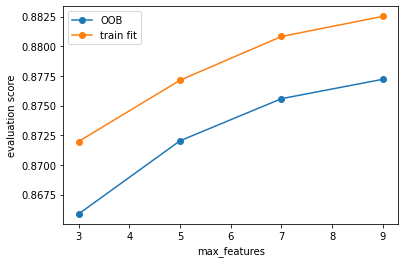

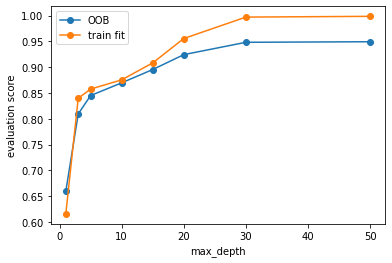

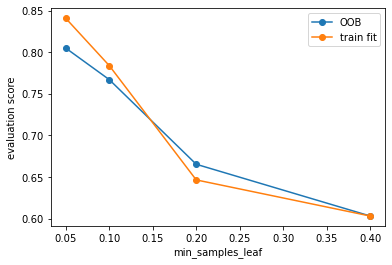

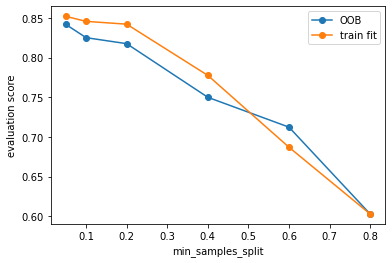

In [18]:
# Plot OOB score as function of max_features
d = {"n_estimators":[10], "max_depth":[10], "min_samples_leaf":[1], "min_samples_split":[2], "max_features":[3, 5, 7, 9]}
OOB_hyperparameter_grid(d, hyperparameter = "max_features")

# Plot OOB score as function of max_depth
d = {"n_estimators":[10], "max_depth":[1, 3, 5, 10, 15, 20, 30, 50], "min_samples_leaf":[1], "min_samples_split":[2], "max_features":[4]}
OOB_hyperparameter_grid(d, hyperparameter = "max_depth")

# Plot OOB score as function of min_samples_leaf
d = {"n_estimators":[10], "max_depth":[10], "min_samples_leaf":[0.05, 0.1, 0.20, 0.40], "min_samples_split":[2], "max_features":[4]}
OOB_hyperparameter_grid(d, hyperparameter = "min_samples_leaf")

# Plot OOB score as function of min_samples_split
d = {"n_estimators":[10], "max_depth":[10], "min_samples_leaf":[1], "min_samples_split":[0.05, 0.1, 0.2, 0.4, 0.6, 0.8], "max_features":[4]}
OOB_hyperparameter_grid(d, hyperparameter = "min_samples_split")

#### 5.c Finalised Model

The above results show that:
* Improvement levels off at ~10 estimators.
* Improvement saturates at a max_depth of ~30. I think the model is just starting to overfit (no firther improvement on holdout set), but 30 seems reasonable.
* min_samples_leaf and min_samples_split should both be set to their lowest values (done by default).
* n_features has little impact on the outcome. I'll prefer to keep it low therefore to speed computation and to mitigate overfitting.

The finalised model will use the optimal hyperparameters as defined below:

In [19]:
# Train the model on the training dataset with optimal hyperparameters
final_model = RandomForestClassifier(n_estimators = 20, 
                                     max_depth = 30, 
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     criterion="gini", oob_score=True, random_state=1)
final_model.fit(X_train, y_train)

# Use the model to predict the holdout set and get accuracy scores.
y_predict_holdout = final_model.predict(X_holdout)

print_classifier_scores(y_predict_holdout, y_holdout)

[[642801  20900]
 [ 12989 411008]]
The accuracy is 0.9688433738041258
The recall is 0.9693653492831317
The precision is 0.9516100651064578


The final model yields an accuracy on the unseen holdout set of **97%**. 

This is fairly good. Further tuning or a different model could yield improved results (see conclusion).

### 6. Pipeline Construction
JojaMart wants me to construct a data pipeline for my model so that it can be attached to their data engineers' pipelines.

Since I don't know exactly the shape of JojaMart's data flow, I will construct a basic pipeline here wrapped in a function:

In [20]:
# Bundle the pipeline in a function for ease of use

def preprocess(df_catalogue_discontinuation, df_product_details):
    """
    The various preprocessing steps were distributed over many code cells above. For clarity, 
    I've copied them here in a single function.
    In a real situation, there would be more preprocessing steps such as dealing with missing data.
    ---
    Inputs: 
        - df_catalogue_discontinuation:  dataframe of catalogue_discontinuation of the same type as provided in exercise.
        - df_product_details: dataframe for product_details of the same type as provided in exercise.
    Outputs:
        - A single dataframe with correct encoding for use by the model.
    """
    df = pd.merge(df_catalogue_discontinuation, df_product_details, how="inner", on="ProductKey")
    
    transformation_cols = {"DiscontinuedTF":[True, False],   # These are to be substituted with [1, 0]
                           "SpringSummer":[True, False], 
                           "Seasonal":[True, False], 
                           "Status":["RI", "RO"], 
                           "DIorDOM":["DI", "DOM"],
                          }

    for key, value in transformation_cols.items():
        df[key] = df[key].replace(value, [1,0])
    
    df = df.drop(["CatEdition"], axis = 1)

    if "DiscontinuedTF" in df:
        df = df.drop(["DiscontinuedTF"], axis=1)  # Future data wouldn't have the DiscontinuedTF column. Drop it in case it
                                                  # presents is included.
    return df
    
def pipeline(df_catalogue_discontinuation, df_product_details):
    """
    Pipeline for predicting expected discontinuation of an object given its feature data.
    ---
    Inputs: 
        - df_catalogue_discontinuation:  dataframe of catalogue_discontinuation of the same type as provided in exercise.
        - df_product_details: dataframe for product_details of the same type as provided in exercise.
    ---
    Returns:
        - Expected True / False value for if an given product will be discontinued or not.
    
    """
    x_processed = preprocess(df_catalogue_discontinuation, df_product_details)
    prediction = final_model.predict(x_processed)
    prediction_df = pd.DataFrame(prediction, columns=["Discontinued Prediction"])
    
    # Convert 0 / 1 returned by model back to True / False to be consistent with data file.
    prediction_df["Discontinued Prediction"] = prediction_df["Discontinued Prediction"].replace([1, 0], [True, False])  

   
    return(prediction_df)


# Test the pipeline:

# An example new product that I made up in the 99th catalogue 
example_cat_disc = pd.DataFrame([[99, True, 20000, -10, "RI", 1000.00, 100, 80, True]], 
                                columns = ["CatEdition", "SpringSummer", "ProductKey", "WeeksOut", "Status", \
                                           "SalePriceIncVAT", "ForecastPerWeek", "ActualsPerWeek", "DiscontinuedTF"])

# The example product details for this product
example_prod_det = pd.DataFrame([[20000, 1, 300, 20, "DI", True]], 
                                columns = ["ProductKey", "Supplier", "HierarchyLevel1", "HierarchyLevel2", \
                                           "DIorDOM", "Seasonal"])

# Run the data through the pipeline
example_result = pipeline(example_cat_disc, example_prod_det)
#example_result = pipeline(catalogue_discontinuation, product_details) # test on the entire dataset (works!)

# Print the result of the prediction for this product.
print(example_result)
    

  Discontinued Prediction
0                   False


The above pipeline works as expected.

### 7. Conclusion & Summary



In this project for JojaMart, I trained a Random Forest model for binary classification.

The model predicts which products will be discontinued in the next Range Refresh with an estimated accuracy score of **97%**, measured by testing on an unseen holdout dataset. 

To arrive at this result, I first performed EDA, and investigated the data supplied. Finding no missing data, I chose to train a relatively simple Logistic Regression model, which performed poorly on the prediction task (low ROC AUC score, etc).

I therefore tried a more complex model. The initial result of the Random Forest was ~92% accuracy. This was a promising result, so I then optimised some hyperparameters of the model, which yielded the final accuracy of 97%.

I packaged the trained model into a data pipeline for use by the data engineers.

I think this is a good first result, but I am sure the prediction accuracy could be improved further:

### Improvements to the Model:

Ideas to yield a better accuracy include:

* **Use of a different model**:
    * Given the amount of data available (3.6M samples), I think a neural network (NN) could be trained. Cutting edge NN's can yield accuracies of >99%, which would be an improvement. I chose not to impement this approach, as a random forest is slightly more interpretable, and NN training requires considerable computational resources.

* **Feature engineering**:
    * I could go back to the preprocessing step and try some feature engineering, which may yield improved results.

* **More data features**: a more informative model could be generated by using of a more complex dataset with more features. These new features could be selected by considering business considerations. For example:
    *  Profit margins drive revenue: the cost price of items is not listed, so we were unable to capture revenue data.
    *  Item size: This is important for inventory management and would likely affect the prediction.
    *  Competitor information, e.g. competitor sales price
    *  Weather: e.g. seasonal clothing sales could be affected by unseasonal weather

### <span style="color:orange">Find more of my work [here on GitHub](https://github.com/rvbrooks)!</span>